# Stereotyped concepts
In the following notebook we're going to investigate three different gender stereotyped concepts: science vs arts, career vs family and agency vs communion. We will use all the approaches we developed so far and we'll use both FastText's and Gonen's embeddings.

In [1]:
# general
import pandas as pd
import numpy as np
import scipy.stats
import codecs
from matplotlib import pyplot as plt
from numpy import linalg as LA

# bolukbasi's
import debiaswe as dwe
import debiaswe.we as we
from debiaswe.we import WordEmbedding

# mine
import db_functions as db

### Step 1: Load embeddings

We load all the emdeddings using the same methods and applying the same preprocessing in order to have a common start.

In [2]:
# load Gonen's emdebbings
E_g =  WordEmbedding('../gonen/embeddings/it_lemma_to_fem', 'g')

*** Reading data from ../gonen/embeddings/it_lemma_to_fem
(160597, 300)
160597 words of dimension 300 : </s>, ,, di, ., ..., title="henrik, pass">, title="nils, title="derrick
160597 words of dimension 300 : </s>, ,, di, ., ..., title="henrik, pass">, title="nils, title="derrick


In [3]:
# load FastText's emdeddings
E_ft =  WordEmbedding('../bolukbasi/mio/embeddings/cc.it.300.vec', 'ft')

*** Reading data from ../bolukbasi/mio/embeddings/cc.it.300.vec
(2000000, 300)
2000000 words of dimension 300 : ,, di, ., </s>, ..., Kelyn, golfclub, metallo-organici, ricercaLatin
2000000 words of dimension 300 : ,, di, ., </s>, ..., Kelyn, golfclub, metallo-organici, ricercaLatin


### Step 2: working whit FastText's embeddings

### Step 2.1: vector difference

In [4]:
# gender direction
g_diff = E_ft.diff('lui', 'lei')

#### Step 2.2: PCA

In [5]:
# list of pairs to define gender
gender_pairs = [['lui','lei'],
                ['uomo','donna'], 
                ['padre','madre'],
                ['marito','moglie'],
                ['fratello','sorella'],
                ['maschio','femmina']]

In [6]:
# PCA
pca = we.doPCA(gender_pairs, E_ft)

# PCA components
pc = pca.components_

# singular values
sv = pca.singular_values_

In [7]:
print("Singular values:")
print(sv)

Singular values:
[9.5309240e-01 5.3566736e-01 3.7772956e-01 3.4538972e-01 2.9901835e-01
 2.4023318e-01 5.8411594e-08 4.6098762e-08 4.3273410e-08 4.1712632e-08]


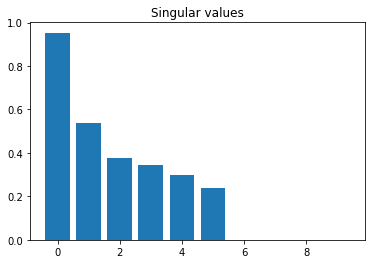

In [8]:
plt.bar(range(pca.n_components_), sv)
plt.title("Singular values")
plt.show()

In [9]:
# gender direction
g_pca_0  = pc[0]/LA.norm(pc[0])
g_pca_01 = (sv[0]*pc[0]+sv[1]*pc[1])/(sv[0]+sv[1])/LA.norm((sv[0]*pc[0]+sv[1]*pc[1])/(sv[0]+sv[1]))

#### Step 2.3: pseudo-LDA

In [10]:
S_word = [['lui','lei'],
          ['uomo','donna'], 
          ['padre','madre'],
          ['marito','moglie'],
          ['fratello','sorella'],
          ['maschio','femmina']]

G_word = db.read('gram_def_mf.txt', 'mf')

In [11]:
S_m_v = []
for w in S_word:
    S_m_v.append(E_ft.v(w[1]))
    
S_f_v = []
for w in S_word:
    S_f_v.append(E_ft.v(w[0]))
    
G_m_v = []
for w in G_word:
    G_m_v.append(E_ft.v(w[0]))
    
G_f_v = []
for w in G_word:
    G_f_v.append(E_ft.v(w[1]))

S_m = np.array(S_m_v).T
S_f = np.array(S_f_v).T
G_m = np.array(G_m_v).T
G_f = np.array(G_f_v).T

In [12]:
# delta semantic
Delta_S = np.dot(np.subtract(S_m, S_f), np.subtract(S_m, S_f).T)

# delta grammatical
Delta_G = np.dot(np.subtract(G_m, G_f), np.subtract(G_m, G_f).T)

# A
A = np.dot(np.linalg.inv(Delta_G), Delta_S)

In [13]:
# eigenvalues and eigenvectors
w, v = np.linalg.eig(A)

# gender direction: pick the eigenvector associated to the largest eigenvalue
g_e = v[:,np.argmax(w)] # already normalized

#### Step 2.4: science vs arts
The words for science and arts are the ones used by the Italian IAT, https://implicit.harvard.edu/implicit/italy/.

In [14]:
# words
science = ['biologia', 'fisica', 'chimica', 'matematica', 'geologia', 'astronomia', 'ingegneria']
art = ['filosofia', 'umanesimo', 'arte', 'letteratura', 'italiano', 'musica', 'storia']

In [15]:
# compute projections
proj_science_g_diff =  db.prof_proj(E_ft, science, g_diff, 'm')
proj_science_g_pca_0 =  db.prof_proj(E_ft, science, g_pca_0, 'm')
proj_science_g_pca_01 =  db.prof_proj(E_ft, science, g_pca_01, 'm')
proj_science_g_e =  db.prof_proj(E_ft, science, g_e, 'm')

proj_art_g_diff =  db.prof_proj(E_ft, art, g_diff, 'm')
proj_art_g_pca_0 =  db.prof_proj(E_ft, art, g_pca_0, 'm')
proj_art_g_pca_01 =  db.prof_proj(E_ft, art, g_pca_01, 'm')
proj_art_g_e =  db.prof_proj(E_ft, art, g_e, 'm')

In [16]:
# print science results
science_col0 = [] # pandas columns
science_col1 = []
science_col2 = []
science_col3 = []
science_col4 = []

for i in range(len(proj_art_g_diff)):
    science_col0.append(proj_science_g_diff[i][0]) # word
    science_col1.append(proj_science_g_diff[i][1]) # projection on g_diff
    science_col2.append(proj_science_g_pca_0[i][1]) # projection on g_pca_0
    science_col3.append(proj_science_g_pca_01[i][1]) # projection on g_pca_01
    science_col4.append(np.real(proj_science_g_e[i][1])) # projection on g_e
    
mean_science_g_diff = np.mean(science_col1)
mean_science_g_pca_0 = np.mean(science_col2)
mean_science_g_pca_01 = np.mean(science_col3)
mean_science_g_e = np.mean(science_col4)

science_col0.append('MEAN')
science_col1.append(mean_science_g_diff)
science_col2.append(mean_science_g_pca_0)
science_col3.append(mean_science_g_pca_01)
science_col4.append(mean_science_g_e)

science_data = {'Word':science_col0, 
           'Proj g_diff':science_col1,
           'Proj g_pca_0':science_col2, 
           'Proj g_pca_01':science_col3,
           'Proj g_e':science_col4}

science_table = pd.DataFrame(science_data)
science_table

,Word,Proj g_diff,Proj g_pca_0,Proj g_pca_01,Proj g_e
0,biologia,-0.055746,-0.124392,-0.059443,-0.004077
1,fisica,0.054857,-0.061929,0.000047,0.018897
2,chimica,-0.042915,-0.114037,-0.077102,0.059681
3,matematica,-0.011316,-0.078993,-0.049179,0.027182
4,geologia,0.028853,-0.057915,0.009817,0.037508
5,astronomia,-0.014668,-0.011514,0.026787,-0.092121
6,ingegneria,0.013448,-0.004664,0.032717,0.084291
7,MEAN,-0.003927,-0.064778,-0.016622,0.018766


In [17]:
# print arts results
art_col0 = [] # pandas columns
art_col1 = []
art_col2 = []
art_col3 = []
art_col4 = []

for i in range(len(proj_art_g_diff)):
    art_col0.append(proj_art_g_diff[i][0]) # word
    art_col1.append(proj_art_g_diff[i][1]) # projection on g_diff
    art_col2.append(proj_art_g_pca_0[i][1]) # projection on g_pca_0
    art_col3.append(proj_art_g_pca_01[i][1]) # projection on g_pca_01
    art_col4.append(np.real(proj_art_g_e[i][1])) # projection on g_e
    
mean_art_g_diff = np.mean(art_col1)
mean_art_g_pca_0 = np.mean(art_col2)
mean_art_g_pca_01 = np.mean(art_col3)
mean_art_g_e = np.mean(art_col4)

art_col0.append('MEAN')
art_col1.append(mean_art_g_diff)
art_col2.append(mean_art_g_pca_0)
art_col3.append(mean_art_g_pca_01)
art_col4.append(mean_art_g_e)

art_data = {'Word':art_col0, 
           'Proj g_diff':art_col1,
           'Proj g_pca_0':art_col2, 
           'Proj g_pca_01':art_col3,
           'Proj g_e':art_col4}

art_table = pd.DataFrame(art_data)
art_table

,Word,Proj g_diff,Proj g_pca_0,Proj g_pca_01,Proj g_e
0,filosofia,0.021588,-0.112595,-0.026920,-0.001847
1,umanesimo,0.106405,0.249317,0.233202,-0.034585
2,arte,-0.029573,-0.091655,-0.026101,0.055406
3,letteratura,-0.067251,-0.183330,-0.130702,0.010203
4,italiano,0.090899,0.139625,0.120780,0.017075
5,musica,0.005222,-0.151351,-0.081946,0.018445
6,storia,0.005462,-0.164054,-0.067754,0.031733
7,MEAN,0.018965,-0.044863,0.002937,0.013776


#### Step 2.5: career vs family
For family and career we translated to Italian the English words used by Caliskan, Bryson and Narayanan in "Semantics derived automatically from language corpora necessarily contain human biases", https://arxiv.org/abs/1608.07187.

In [18]:
# words
# executive, management, professional, corporation, salary, office, business, career
career = ['esecutivo', 'amministrazione', 'professionale', 'società', 'stipendio', 'ufficio', 'business', 'carriera']
# home, parents, children, family, cousins, marriage, wedding, relatives
family = ['casa', 'genitori', 'bambini', 'famiglia', 'cugini', 'matrimonio', 'parenti']

In [19]:
# compute projections
proj_career_g_diff =  db.prof_proj(E_ft, career, g_diff, 'm')
proj_career_g_pca_0 =  db.prof_proj(E_ft, career, g_pca_0, 'm')
proj_career_g_pca_01 =  db.prof_proj(E_ft, career, g_pca_01, 'm')
proj_career_g_e =  db.prof_proj(E_ft, career, g_e, 'm')

proj_family_g_diff =  db.prof_proj(E_ft, family, g_diff, 'm')
proj_family_g_pca_0 =  db.prof_proj(E_ft, family, g_pca_0, 'm')
proj_family_g_pca_01 =  db.prof_proj(E_ft, family, g_pca_01, 'm')
proj_family_g_e =  db.prof_proj(E_ft, family, g_e, 'm')

In [20]:
# print career results
career_col0 = [] # pandas columns
career_col1 = []
career_col2 = []
career_col3 = []
career_col4 = []

for i in range(len(proj_career_g_diff)):
    career_col0.append(proj_career_g_diff[i][0]) # word
    career_col1.append(proj_career_g_diff[i][1]) # projection on g_diff
    career_col2.append(proj_career_g_pca_0[i][1]) # projection on g_pca_0
    career_col3.append(proj_career_g_pca_01[i][1]) # projection on g_pca_01
    career_col4.append(np.real(proj_career_g_e[i][1])) # projection on g_e
    
mean_career_g_diff = np.mean(career_col1)
mean_career_g_pca_0 = np.mean(career_col2)
mean_career_g_pca_01 = np.mean(career_col3)
mean_career_g_e = np.mean(career_col4)

career_col0.append('MEAN')
career_col1.append(mean_career_g_diff)
career_col2.append(mean_career_g_pca_0)
career_col3.append(mean_career_g_pca_01)
career_col4.append(mean_career_g_e)

career_data = {'Word':career_col0, 
               'Proj g_diff':career_col1,
               'Proj g_pca_0':career_col2, 
               'Proj g_pca_01':career_col3,
               'Proj g_e':career_col4}

career_table = pd.DataFrame(career_data)
career_table

,Word,Proj g_diff,Proj g_pca_0,Proj g_pca_01,Proj g_e
0,esecutivo,0.055391,0.172649,0.139956,0.056442
1,amministrazione,-0.032690,-0.127691,-0.053607,0.026870
2,professionale,-0.019062,-0.011071,-0.030170,-0.000007
3,società,-0.020540,-0.206441,-0.115734,-0.001511
4,stipendio,0.053302,0.134012,0.083870,0.004798
5,ufficio,0.012081,0.130737,0.080650,0.060978
6,business,0.019688,0.122475,0.066698,0.065524
7,carriera,0.036085,-0.140870,-0.056135,0.040397
8,MEAN,0.013032,0.009225,0.014441,0.031686


In [21]:
# print family results
family_col0 = [] # pandas columns
family_col1 = []
family_col2 = []
family_col3 = []
family_col4 = []

for i in range(len(proj_art_g_diff)):
    family_col0.append(proj_family_g_diff[i][0]) # word
    family_col1.append(proj_family_g_diff[i][1]) # projection on g_diff
    family_col2.append(proj_family_g_pca_0[i][1]) # projection on g_pca_0
    family_col3.append(proj_family_g_pca_01[i][1]) # projection on g_pca_01
    family_col4.append(np.real(proj_family_g_e[i][1])) # projection on g_e
    
mean_family_g_diff = np.mean(family_col1)
mean_family_g_pca_0 = np.mean(family_col2)
mean_family_g_pca_01 = np.mean(family_col3)
mean_family_g_e = np.mean(family_col4)

family_col0.append('MEAN')
family_col1.append(mean_family_g_diff)
family_col2.append(mean_family_g_pca_0)
family_col3.append(mean_family_g_pca_01)
family_col4.append(mean_family_g_e)

family_data = {'Word':family_col0, 
               'Proj g_diff':family_col1,
               'Proj g_pca_0':family_col2, 
               'Proj g_pca_01':family_col3,
               'Proj g_e':family_col4}

family_table = pd.DataFrame(family_data)
family_table

,Word,Proj g_diff,Proj g_pca_0,Proj g_pca_01,Proj g_e
0,casa,0.017944,-0.215910,-0.127106,0.000448
1,genitori,-0.018512,-0.035270,-0.076613,0.025550
2,bambini,-0.021609,-0.081263,-0.084579,-0.020437
3,famiglia,-0.030836,-0.186688,-0.136030,0.014595
4,cugini,0.094278,0.057158,0.062268,0.072945
5,matrimonio,-0.092759,0.066864,-0.060417,0.019470
6,parenti,0.040844,-0.038468,-0.036367,0.072880
7,MEAN,-0.001521,-0.061940,-0.065549,0.026493


#### Step 2.6: agency vs communion
For agency and communion we used the same adjectives used by Abele, Uchronski, Suitner and Wojciszke in "Towards an operationalization of the fundamental dimensions of agency and communion: Trait content ratings in five countries considering valence and
frequency of word occurrence", https://onlinelibrary.wiley.com/doi/epdf/10.1002/ejsp.575.

In [22]:
import importlib
importlib.reload(db)

<module 'db_functions' from '/Users/davidebiasion/Documents/tesi/prova dati/comparativa-concetti/db_functions.py'>

In [23]:
# words
agency = db.read('ag_ita.txt', 'ag-com')
communion = db.read('com_ita.txt', 'ag-com')

In [24]:
agency_pos = ['abile', 'attivo', 'creativo', 'indipendente', 'intelligente', 'determinato', 'razionale', 'autonomo',
         'deciso', 'capace', 'competente', 'vigoroso', 'combattivo', 'ambizioso']

communion_pos = ['educato', 'giusto', 'aperto', 'disponibile', 'leale', 'sensibile', 'empatico', 'fiducioso', 'comprensivo', 
                 'coscienzioso', 'supportivo', 'altruista']

agency_lack = ['timido', 'credulone', 'vulnerabile']

communion_lack = ['distaccato', 'egoista', 'rigido']

In [25]:
# compute projections
proj_agency_g_diff =  db.prof_proj(E_ft, agency, g_diff, 'ag-com')
proj_agency_g_pca_0 =  db.prof_proj(E_ft, agency, g_pca_0, 'ag-com')
proj_agency_g_pca_01 =  db.prof_proj(E_ft, agency, g_pca_01, 'ag-com')
proj_agency_g_e =  db.prof_proj(E_ft, agency, g_e, 'ag-com')

proj_communion_g_diff =  db.prof_proj(E_ft, communion, g_diff, 'ag-com')
proj_communion_g_pca_0 =  db.prof_proj(E_ft, communion, g_pca_0, 'ag-com')
proj_communion_g_pca_01 =  db.prof_proj(E_ft, communion, g_pca_01, 'ag-com')
proj_communion_g_e =  db.prof_proj(E_ft, communion, g_e, 'ag-com')

In [26]:
# print agency results
agency_col0 = [] # pandas columns
agency_col1 = []
agency_col2 = []
agency_col3 = []
agency_col4 = []
agency_col5 = []

for i in range(len(proj_agency_g_diff)):
    agency_col0.append(proj_agency_g_diff[i][0]) # word
    agency_col1.append(proj_agency_g_diff[i][1]) # projection on g_diff
    agency_col2.append(proj_agency_g_pca_0[i][1]) # projection on g_pca_0
    agency_col3.append(proj_agency_g_pca_01[i][1]) # projection on g_pca_01
    agency_col4.append(np.real(proj_agency_g_e[i][1])) # projection on g_e
    agency_col5.append(proj_agency_g_diff[i][2]) # agency score
    
mean_agency_g_diff = np.mean(agency_col1)
mean_agency_g_pca_0 = np.mean(agency_col2)
mean_agency_g_pca_01 = np.mean(agency_col3)
mean_agency_g_e = np.mean(agency_col4)
mean_agency_score = np.mean(agency_col5)

agency_col0.append('MEAN')
agency_col1.append(mean_agency_g_diff)
agency_col2.append(mean_agency_g_pca_0)
agency_col3.append(mean_agency_g_pca_01)
agency_col4.append(mean_agency_g_e)
agency_col5.append(mean_agency_score)

agency_data = {'Word':agency_col0, 
               'Proj g_diff':agency_col1,
               'Proj g_pca_0':agency_col2, 
               'Proj g_pca_01':agency_col3,
               'Proj g_e':agency_col4,
               'Agency':agency_col5}

agency_table = pd.DataFrame(agency_data)
agency_table

,Word,Proj g_diff,Proj g_pca_0,Proj g_pca_01,Proj g_e,Agency
0,abile,0.080335,0.102190,0.122643,-0.104315,2.320000
1,attivo,0.133193,0.196107,0.180168,-0.056429,2.350000
2,ambizioso,0.152494,0.288911,0.251100,-0.012472,2.790000
3,deciso,0.033273,0.090033,0.046084,-0.009320,2.880000
4,vanitoso,0.105291,0.191813,0.171161,-0.027970,1.290000
5,capace,0.059239,0.016343,0.053817,-0.042131,2.450000
6,competente,0.001019,0.001375,-0.003906,-0.059758,2.210000
7,competitivo,0.072216,0.153743,0.123873,0.033614,2.710000
8,presuntuoso,0.112785,0.230236,0.198067,-0.019344,1.530000
9,creativo,0.049542,0.171296,0.115495,0.069760,1.630000


In [27]:
# agency pearson correlation
r_agency_g_diff = scipy.stats.pearsonr(agency_col5, agency_col1)[0]
r_agency_g_pca_0 = scipy.stats.pearsonr(agency_col5, agency_col2)[0]
r_agency_g_pca_01 = scipy.stats.pearsonr(agency_col5, agency_col3)[0]
r_agency_g_e = scipy.stats.pearsonr(agency_col5, agency_col4)[0]

In [28]:
pearson_data = {'g_diff':r_agency_g_diff,
                'g_pca_0':r_agency_g_pca_0,
                'g_pca_01':r_agency_g_pca_01,
                'g_e':r_agency_g_e}
pearson_table = pd.DataFrame(pearson_data, index=['r'])
pearson_table

,g_diff,g_pca_0,g_pca_01,g_e
r,0.217142,0.035881,0.079808,0.068427


In [29]:
# print communion results
communion_col0 = [] # pandas columns
communion_col1 = []
communion_col2 = []
communion_col3 = []
communion_col4 = []
communion_col5 = []

for i in range(len(proj_communion_g_diff)):
    communion_col0.append(proj_communion_g_diff[i][0]) # word
    communion_col1.append(proj_communion_g_diff[i][1]) # projection on g_diff
    communion_col2.append(proj_communion_g_pca_0[i][1]) # projection on g_pca_0
    communion_col3.append(proj_communion_g_pca_01[i][1]) # projection on g_pca_01
    communion_col4.append(np.real(proj_communion_g_e[i][1])) # projection on g_e
    communion_col5.append(proj_communion_g_diff[i][2]) # communion score
    
mean_communion_g_diff = np.mean(communion_col1)
mean_communion_g_pca_0 = np.mean(communion_col2)
mean_communion_g_pca_01 = np.mean(communion_col3)
mean_communion_g_e = np.mean(communion_col4)
mean_communion_score = np.mean(communion_col5)

communion_col0.append('MEAN')
communion_col1.append(mean_communion_g_diff)
communion_col2.append(mean_communion_g_pca_0)
communion_col3.append(mean_communion_g_pca_01)
communion_col4.append(mean_communion_g_e)
communion_col5.append(mean_communion_score)

communion_data = {'Word':communion_col0, 
               'Proj g_diff':communion_col1,
               'Proj g_pca_0':communion_col2, 
               'Proj g_pca_01':communion_col3,
               'Proj g_e':communion_col4,
               'communion':communion_col5}

communion_table = pd.DataFrame(communion_data)
communion_table

,Word,Proj g_diff,Proj g_pca_0,Proj g_pca_01,Proj g_e,communion
0,affettuoso,0.059949,0.173368,0.126707,0.007737,1.580000
1,altruista,-0.014515,0.007354,0.004393,-0.039926,2.500000
2,comunicativo,0.085256,0.186069,0.156890,0.062600,2.000000
3,coscienzioso,0.080623,0.233943,0.178483,0.031092,1.320000
4,rispettoso,0.003357,0.081186,0.073712,-0.005914,1.550000
5,coerente,0.008640,0.028646,0.026779,-0.006384,1.680000
6,emotivo,0.002176,0.138984,0.072085,0.063686,1.370000
7,giusto,0.019891,0.138324,0.074450,-0.059111,1.950000
8,socievole,-0.003064,0.009935,0.004534,-0.031136,2.230000
9,disponibile,-0.029067,-0.036633,-0.032159,-0.094269,2.760000


In [30]:
# communion pearson correlation
r_communion_g_diff = scipy.stats.pearsonr(communion_col5, communion_col1)[0]
r_communion_g_pca_0 = scipy.stats.pearsonr(communion_col5, communion_col2)[0]
r_communion_g_pca_01 = scipy.stats.pearsonr(communion_col5, communion_col3)[0]
r_communion_g_e = scipy.stats.pearsonr(communion_col5, communion_col4)[0]

In [31]:
pearson_data = {'g_diff':r_communion_g_diff,
                'g_pca_0':r_communion_g_pca_0,
                'g_pca_01':r_communion_g_pca_01,
                'g_e':r_communion_g_e}
pearson_table = pd.DataFrame(pearson_data, index=['r'])
pearson_table

,g_diff,g_pca_0,g_pca_01,g_e
r,-0.315446,-0.355271,-0.319628,-0.429704


In [35]:
proj_lui_g_diff = np.dot(E_ft.v('lui'), g_diff)
print(proj_lui_g_diff)

0.35057753


In [36]:
proj_lei_g_diff = np.dot(E_ft.v('lei'), g_diff)
print(proj_lei_g_diff)

-0.3505773


In [37]:
proj_lui_g_pca_0 = np.dot(E_ft.v('lui'), g_pca_0)
print(proj_lui_g_pca_0)

0.17376208


In [38]:
proj_lei_g_pca_0 = np.dot(E_ft.v('lei'), g_pca_0)
print(proj_lei_g_pca_0)

-0.22439247


In [40]:
proj_uomo_g_diff = np.dot(E_ft.v('uomo'), g_diff)
print(proj_uomo_g_diff)

0.15894529


In [41]:
proj_donna_g_diff = np.dot(E_ft.v('donna'), g_diff)
print(proj_donna_g_diff)

-0.2671539


In [42]:
proj_uomo_g_pca_0 = np.dot(E_ft.v('uomo'), g_pca_0)
print(proj_uomo_g_pca_0)

0.2682752


In [43]:
proj_donna_g_pca_0 = np.dot(E_ft.v('donna'), g_pca_0)
print(proj_donna_g_pca_0)

-0.387469


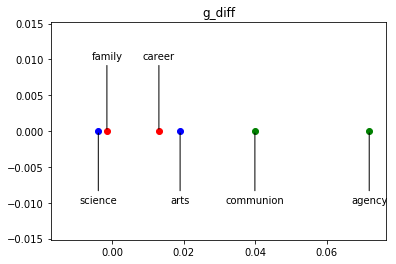

In [32]:
# concepts plot g_diff
fig, ax = plt.subplots()
ax.scatter([mean_science_g_diff, mean_art_g_diff], [0, 0], color='blue')
ax.scatter([mean_career_g_diff, mean_family_g_diff], [0, 0], color='red')
ax.scatter([mean_agency_g_diff, mean_communion_g_diff], [0, 0], color='green')
ax.set_title('g_diff')

plt.annotate('science',
            xy=(mean_science_g_diff, 0),
            xytext=(mean_science_g_diff, -0.01), 
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))
plt.annotate('arts',
            xy=(mean_art_g_diff, 0),
            xytext=(mean_art_g_diff, -0.01), 
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))
plt.annotate('career',
            xy=(mean_career_g_diff, 0),
            xytext=(mean_career_g_diff, 0.01), 
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))
plt.annotate('family',
            xy=(mean_family_g_diff, 0),
            xytext=(mean_family_g_diff, 0.01), 
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))
plt.annotate('agency',
            xy=(mean_agency_g_diff, 0),
            xytext=(mean_agency_g_diff, -0.01), 
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))
plt.annotate('communion',
            xy=(mean_communion_g_diff, 0),
            xytext=(mean_communion_g_diff, -0.01), 
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))

plt.show()
fig.savefig('plot/ft_g_diff')

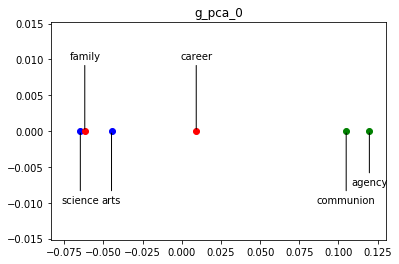

In [33]:
# concepts plot g_pca_0
fig, ax = plt.subplots()
ax.scatter([mean_science_g_pca_0, mean_art_g_pca_0], [0, 0], color='blue')
ax.scatter([mean_career_g_pca_0, mean_family_g_pca_0], [0, 0], color='red')
ax.scatter([mean_agency_g_pca_0, mean_communion_g_pca_0], [0, 0], color='green')
ax.set_title('g_pca_0')

plt.annotate('science',
            xy=(mean_science_g_pca_0, 0),
            xytext=(mean_science_g_pca_0, -0.01), 
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))
plt.annotate('arts',
            xy=(mean_art_g_pca_0, 0),
            xytext=(mean_art_g_pca_0, -0.01), 
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))
plt.annotate('career',
            xy=(mean_career_g_pca_0, 0),
            xytext=(mean_career_g_pca_0, 0.01), 
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))
plt.annotate('family',
            xy=(mean_family_g_pca_0, 0),
            xytext=(mean_family_g_pca_0, 0.01), 
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))
plt.annotate('agency',
            xy=(mean_agency_g_pca_0, 0),
            xytext=(mean_agency_g_pca_0, -0.0075), 
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))
plt.annotate('communion',
            xy=(mean_communion_g_pca_0, 0),
            xytext=(mean_communion_g_pca_0, -0.01), 
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))

plt.show()
fig.savefig('plot/ft_g_pca_0')

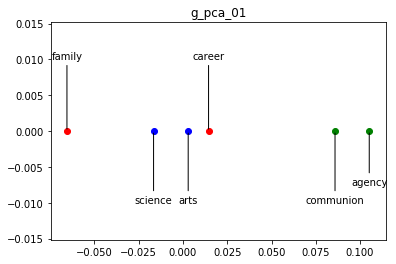

In [34]:
# concepts plot g_pca_01
fig, ax = plt.subplots()
ax.scatter([mean_science_g_pca_01, mean_art_g_pca_01], [0, 0], color='blue')
ax.scatter([mean_career_g_pca_01, mean_family_g_pca_01], [0, 0], color='red')
ax.scatter([mean_agency_g_pca_01, mean_communion_g_pca_01], [0, 0], color='green')
ax.set_title('g_pca_01')

plt.annotate('science',
            xy=(mean_science_g_pca_01, 0),
            xytext=(mean_science_g_pca_01, -0.01), 
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))
plt.annotate('arts',
            xy=(mean_art_g_pca_01, 0),
            xytext=(mean_art_g_pca_01, -0.01), 
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))
plt.annotate('career',
            xy=(mean_career_g_pca_01, 0),
            xytext=(mean_career_g_pca_01, 0.01), 
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))
plt.annotate('family',
            xy=(mean_family_g_pca_01, 0),
            xytext=(mean_family_g_pca_01, 0.01), 
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))
plt.annotate('agency',
            xy=(mean_agency_g_pca_01, 0),
            xytext=(mean_agency_g_pca_01, -0.0075), 
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))
plt.annotate('communion',
            xy=(mean_communion_g_pca_01, 0),
            xytext=(mean_communion_g_pca_01, -0.01), 
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))

plt.show()
fig.savefig('plot/ft_g_pca_01')

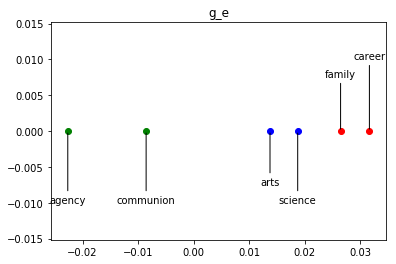

In [35]:
# concepts plot g_e
fig, ax = plt.subplots()
ax.scatter([mean_science_g_e, mean_art_g_e], [0, 0], color='blue')
ax.scatter([mean_career_g_e, mean_family_g_e], [0, 0], color='red')
ax.scatter([mean_agency_g_e, mean_communion_g_e], [0, 0], color='green')
ax.set_title('g_e')

plt.annotate('science',
            xy=(mean_science_g_e, 0),
            xytext=(mean_science_g_e, -0.01), 
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))
plt.annotate('arts',
            xy=(mean_art_g_e, 0),
            xytext=(mean_art_g_e, -0.0075), 
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))
plt.annotate('career',
            xy=(mean_career_g_e, 0),
            xytext=(mean_career_g_e, 0.01), 
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))
plt.annotate('family',
            xy=(mean_family_g_e, 0),
            xytext=(mean_family_g_e, 0.0075), 
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))
plt.annotate('agency',
            xy=(mean_agency_g_e, 0),
            xytext=(mean_agency_g_e, -0.01), 
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))
plt.annotate('communion',
            xy=(mean_communion_g_e, 0),
            xytext=(mean_communion_g_e, -0.01), 
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))

plt.show()
fig.savefig('plot/ft_g_e')

#### Step 2.7: subtracting grammatical gender to the emdeddings

In [36]:
from debiaswe.debias import debias

In [37]:
debias(E_ft, [], G_word, [])

2000000 words of dimension 300 : ,, di, ., </s>, ..., Kelyn, golfclub, metallo-organici, ricercaLatin
set()
2000000 words of dimension 300 : ,, di, ., </s>, ..., Kelyn, golfclub, metallo-organici, ricercaLatin


#### Step 2.7: repeating Steps 2.1-2.6

In [38]:
# gender direction
g_diff = E_ft.diff('lui', 'lei')

In [39]:
# list of pairs to define gender
gender_pairs = [['lui','lei'],
                ['uomo','donna'], 
                ['padre','madre'],
                ['marito','moglie'],
                ['fratello','sorella'],
                ['maschio','femmina']]

In [40]:
# PCA
pca = we.doPCA(gender_pairs, E_ft)

# PCA components
pc = pca.components_

# singular values
sv = pca.singular_values_

In [41]:
print("Singular values:")
print(sv)

Singular values:
[6.9684738e-01 5.0248235e-01 3.8360339e-01 3.4403831e-01 3.0402446e-01
 2.4636908e-01 6.0329249e-08 4.8515240e-08 4.6014925e-08 3.9377852e-08]


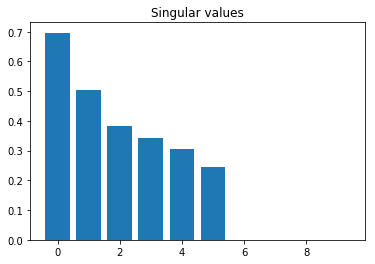

In [42]:
plt.bar(range(pca.n_components_), sv)
plt.title("Singular values")
plt.show()

In [43]:
# gender direction
g_pca_0  = pc[0]/LA.norm(pc[0])
g_pca_01 = (sv[0]*pc[0]+sv[1]*pc[1])/(sv[0]+sv[1])/LA.norm((sv[0]*pc[0]+sv[1]*pc[1])/(sv[0]+sv[1]))

In [44]:
S_word = [['lui','lei'],
          ['uomo','donna'], 
          ['padre','madre'],
          ['marito','moglie'],
          ['fratello','sorella'],
          ['maschio','femmina']]

G_word = db.read('gram_def_mf.txt', 'mf')

In [45]:
S_m_v = []
for w in S_word:
    S_m_v.append(E_ft.v(w[1]))
    
S_f_v = []
for w in S_word:
    S_f_v.append(E_ft.v(w[0]))
    
G_m_v = []
for w in G_word:
    G_m_v.append(E_ft.v(w[0]))
    
G_f_v = []
for w in G_word:
    G_f_v.append(E_ft.v(w[1]))

S_m = np.array(S_m_v).T
S_f = np.array(S_f_v).T
G_m = np.array(G_m_v).T
G_f = np.array(G_f_v).T

In [46]:
# delta semantic
Delta_S = np.dot(np.subtract(S_m, S_f), np.subtract(S_m, S_f).T)

# delta grammatical
Delta_G = np.dot(np.subtract(G_m, G_f), np.subtract(G_m, G_f).T)

# A
A = np.dot(np.linalg.inv(Delta_G), Delta_S)

In [47]:
# eigenvalues and eigenvectors
w, v = np.linalg.eig(A)

# gender direction: pick the eigenvector associated to the largest eigenvalue
g_e = v[:,np.argmax(w)] # already normalized

In [48]:
# words
science = ['biologia', 'fisica', 'chimica', 'matematica', 'geologia', 'astronomia', 'ingegneria']
art = ['filosofia', 'umanesimo', 'arte', 'letteratura', 'italiano', 'musica', 'storia']

In [49]:
# compute projections
proj_science_g_diff =  db.prof_proj(E_ft, science, g_diff, 'm')
proj_science_g_pca_0 =  db.prof_proj(E_ft, science, g_pca_0, 'm')
proj_science_g_pca_01 =  db.prof_proj(E_ft, science, g_pca_01, 'm')
proj_science_g_e =  db.prof_proj(E_ft, science, g_e, 'm')

proj_art_g_diff =  db.prof_proj(E_ft, art, g_diff, 'm')
proj_art_g_pca_0 =  db.prof_proj(E_ft, art, g_pca_0, 'm')
proj_art_g_pca_01 =  db.prof_proj(E_ft, art, g_pca_01, 'm')
proj_art_g_e =  db.prof_proj(E_ft, art, g_e, 'm')

In [50]:
# print science results
science_col0 = [] # pandas columns
science_col1 = []
science_col2 = []
science_col3 = []
science_col4 = []

for i in range(len(proj_art_g_diff)):
    science_col0.append(proj_science_g_diff[i][0]) # word
    science_col1.append(proj_science_g_diff[i][1]) # projection on g_diff
    science_col2.append(proj_science_g_pca_0[i][1]) # projection on g_pca_0
    science_col3.append(proj_science_g_pca_01[i][1]) # projection on g_pca_01
    science_col4.append(np.real(proj_science_g_e[i][1])) # projection on g_e
    
mean_science_g_diff = np.mean(science_col1)
mean_science_g_pca_0 = np.mean(science_col2)
mean_science_g_pca_01 = np.mean(science_col3)
mean_science_g_e = np.mean(science_col4)

science_col0.append('MEAN')
science_col1.append(mean_science_g_diff)
science_col2.append(mean_science_g_pca_0)
science_col3.append(mean_science_g_pca_01)
science_col4.append(mean_science_g_e)

science_data = {'Word':science_col0, 
           'Proj g_diff':science_col1,
           'Proj g_pca_0':science_col2, 
           'Proj g_pca_01':science_col3,
           'Proj g_e':science_col4}

science_table = pd.DataFrame(science_data)
science_table

,Word,Proj g_diff,Proj g_pca_0,Proj g_pca_01,Proj g_e
0,biologia,-0.013904,-0.000683,-0.054191,-0.009670
1,fisica,0.121883,0.149772,0.122199,0.064406
2,chimica,0.021052,0.072633,0.079922,0.054825
3,matematica,0.031239,0.039067,0.034364,0.057711
4,geologia,0.066888,0.075763,0.019290,-0.005909
5,astronomia,0.008978,0.077731,0.042669,0.036478
6,ingegneria,0.046315,0.115725,0.091793,0.002235
7,MEAN,0.040350,0.075715,0.048007,0.028582


In [51]:
# print arts results
art_col0 = [] # pandas columns
art_col1 = []
art_col2 = []
art_col3 = []
art_col4 = []

for i in range(len(proj_art_g_diff)):
    art_col0.append(proj_art_g_diff[i][0]) # word
    art_col1.append(proj_art_g_diff[i][1]) # projection on g_diff
    art_col2.append(proj_art_g_pca_0[i][1]) # projection on g_pca_0
    art_col3.append(proj_art_g_pca_01[i][1]) # projection on g_pca_01
    art_col4.append(np.real(proj_art_g_e[i][1])) # projection on g_e
    
mean_art_g_diff = np.mean(art_col1)
mean_art_g_pca_0 = np.mean(art_col2)
mean_art_g_pca_01 = np.mean(art_col3)
mean_art_g_e = np.mean(art_col4)

art_col0.append('MEAN')
art_col1.append(mean_art_g_diff)
art_col2.append(mean_art_g_pca_0)
art_col3.append(mean_art_g_pca_01)
art_col4.append(mean_art_g_e)

art_data = {'Word':art_col0, 
           'Proj g_diff':art_col1,
           'Proj g_pca_0':art_col2, 
           'Proj g_pca_01':art_col3,
           'Proj g_e':art_col4}

art_table = pd.DataFrame(art_data)
art_table

,Word,Proj g_diff,Proj g_pca_0,Proj g_pca_01,Proj g_e
0,filosofia,0.083409,0.084005,0.022727,0.030692
1,umanesimo,0.061582,0.158785,0.121297,0.030336
2,arte,0.014952,0.052701,0.002447,-0.063713
3,letteratura,-0.008745,-0.027659,-0.039447,-0.015739
4,italiano,0.032793,-0.042176,-0.084154,0.013851
5,musica,0.063236,0.014379,-0.020957,-0.008611
6,storia,0.080979,0.066241,0.008550,-0.090614
7,MEAN,0.046887,0.043754,0.001495,-0.014828


In [52]:
# words
# executive, management, professional, corporation, salary, office, business, career
career = ['esecutivo', 'amministrazione', 'professionale', 'società', 'stipendio', 'ufficio', 'business', 'carriera']
# home, parents, children, family, cousins, marriage, wedding, relatives
family = ['casa', 'familiari', 'bambini', 'famiglia', 'cugini', 'matrimonio', 'parenti']

In [53]:
# compute projections
proj_career_g_diff =  db.prof_proj(E_ft, career, g_diff, 'm')
proj_career_g_pca_0 =  db.prof_proj(E_ft, career, g_pca_0, 'm')
proj_career_g_pca_01 =  db.prof_proj(E_ft, career, g_pca_01, 'm')
proj_career_g_e =  db.prof_proj(E_ft, career, g_e, 'm')

proj_family_g_diff =  db.prof_proj(E_ft, family, g_diff, 'm')
proj_family_g_pca_0 =  db.prof_proj(E_ft, family, g_pca_0, 'm')
proj_family_g_pca_01 =  db.prof_proj(E_ft, family, g_pca_01, 'm')
proj_family_g_e =  db.prof_proj(E_ft, family, g_e, 'm')

In [54]:
# print career results
career_col0 = [] # pandas columns
career_col1 = []
career_col2 = []
career_col3 = []
career_col4 = []

for i in range(len(proj_career_g_diff)):
    career_col0.append(proj_career_g_diff[i][0]) # word
    career_col1.append(proj_career_g_diff[i][1]) # projection on g_diff
    career_col2.append(proj_career_g_pca_0[i][1]) # projection on g_pca_0
    career_col3.append(proj_career_g_pca_01[i][1]) # projection on g_pca_01
    career_col4.append(np.real(proj_career_g_e[i][1])) # projection on g_e
    
mean_career_g_diff = np.mean(career_col1)
mean_career_g_pca_0 = np.mean(career_col2)
mean_career_g_pca_01 = np.mean(career_col3)
mean_career_g_e = np.mean(career_col4)

career_col0.append('MEAN')
career_col1.append(mean_career_g_diff)
career_col2.append(mean_career_g_pca_0)
career_col3.append(mean_career_g_pca_01)
career_col4.append(mean_career_g_e)

career_data = {'Word':career_col0, 
               'Proj g_diff':career_col1,
               'Proj g_pca_0':career_col2, 
               'Proj g_pca_01':career_col3,
               'Proj g_e':career_col4}

career_table = pd.DataFrame(career_data)
career_table

,Word,Proj g_diff,Proj g_pca_0,Proj g_pca_01,Proj g_e
0,esecutivo,0.007169,0.044315,0.034879,0.009730
1,amministrazione,0.016095,0.027096,-0.026303,0.037865
2,professionale,-0.012911,-0.010571,0.021730,0.031202
3,società,0.048167,-0.014996,-0.070017,0.079063
4,stipendio,0.006642,-0.015099,0.003367,0.008828
5,ufficio,-0.023451,0.018662,0.040844,0.080797
6,business,-0.017789,0.005001,0.042075,0.081513
7,carriera,0.093204,0.031314,-0.022422,-0.052308
8,MEAN,0.014641,0.010715,0.003019,0.034586


In [55]:
# print family results
family_col0 = [] # pandas columns
family_col1 = []
family_col2 = []
family_col3 = []
family_col4 = []

for i in range(len(proj_art_g_diff)):
    family_col0.append(proj_family_g_diff[i][0]) # word
    family_col1.append(proj_family_g_diff[i][1]) # projection on g_diff
    family_col2.append(proj_family_g_pca_0[i][1]) # projection on g_pca_0
    family_col3.append(proj_family_g_pca_01[i][1]) # projection on g_pca_01
    family_col4.append(np.real(proj_family_g_e[i][1])) # projection on g_e
    
mean_family_g_diff = np.mean(family_col1)
mean_family_g_pca_0 = np.mean(family_col2)
mean_family_g_pca_01 = np.mean(family_col3)
mean_family_g_e = np.mean(family_col4)

family_col0.append('MEAN')
family_col1.append(mean_family_g_diff)
family_col2.append(mean_family_g_pca_0)
family_col3.append(mean_family_g_pca_01)
family_col4.append(mean_family_g_e)

family_data = {'Word':family_col0, 
               'Proj g_diff':family_col1,
               'Proj g_pca_0':family_col2, 
               'Proj g_pca_01':family_col3,
               'Proj g_e':family_col4}

family_table = pd.DataFrame(family_data)
family_table

,Word,Proj g_diff,Proj g_pca_0,Proj g_pca_01,Proj g_e
0,casa,0.080951,-0.059574,-0.121593,0.066629
1,familiari,0.029241,-0.020376,-0.012746,-0.023258
2,bambini,-0.015699,-0.100694,-0.089043,-0.073613
3,famiglia,0.034900,-0.021681,-0.025269,0.002745
4,cugini,0.095450,0.070998,0.065250,-0.015276
5,matrimonio,-0.134123,-0.114593,0.020003,0.098776
6,parenti,0.044496,-0.053127,-0.052557,-0.047629
7,MEAN,0.019317,-0.042721,-0.030851,0.001196


In [56]:
# words
agency = db.read('ag_ita.txt', 'ag-com')
communion = db.read('com_ita.txt', 'ag-com')

In [57]:
agency_pos = ['abile', 'attivo', 'creativo', 'indipendente', 'intelligente', 'determinato', 'razionale', 'autonomo',
         'deciso', 'capace', 'competente', 'vigoroso', 'combattivo', 'ambizioso']

communion_pos = ['educato', 'giusto', 'aperto', 'disponibile', 'leale', 'sensibile', 'empatico', 'fiducioso', 'comprensivo', 
                 'coscienzioso', 'supportivo', 'altruista']

agency_lack = ['timido', 'credulone', 'vulnerabile']

communion_lack = ['distaccato', 'egoista', 'rigido']

In [58]:
# compute projections
proj_agency_g_diff =  db.prof_proj(E_ft, agency, g_diff, 'ag-com')
proj_agency_g_pca_0 =  db.prof_proj(E_ft, agency, g_pca_0, 'ag-com')
proj_agency_g_pca_01 =  db.prof_proj(E_ft, agency, g_pca_01, 'ag-com')
proj_agency_g_e =  db.prof_proj(E_ft, agency, g_e, 'ag-com')

proj_communion_g_diff =  db.prof_proj(E_ft, communion, g_diff, 'ag-com')
proj_communion_g_pca_0 =  db.prof_proj(E_ft, communion, g_pca_0, 'ag-com')
proj_communion_g_pca_01 =  db.prof_proj(E_ft, communion, g_pca_01, 'ag-com')
proj_communion_g_e =  db.prof_proj(E_ft, communion, g_e, 'ag-com')

In [59]:
# print agency results
agency_col0 = [] # pandas columns
agency_col1 = []
agency_col2 = []
agency_col3 = []
agency_col4 = []
agency_col5 = []

for i in range(len(proj_agency_g_diff)):
    agency_col0.append(proj_agency_g_diff[i][0]) # word
    agency_col1.append(proj_agency_g_diff[i][1]) # projection on g_diff
    agency_col2.append(proj_agency_g_pca_0[i][1]) # projection on g_pca_0
    agency_col3.append(proj_agency_g_pca_01[i][1]) # projection on g_pca_01
    agency_col4.append(np.real(proj_agency_g_e[i][1])) # projection on g_e
    agency_col5.append(proj_agency_g_diff[i][2]) # agency score
    
mean_agency_g_diff = np.mean(agency_col1)
mean_agency_g_pca_0 = np.mean(agency_col2)
mean_agency_g_pca_01 = np.mean(agency_col3)
mean_agency_g_e = np.mean(agency_col4)
mean_agency_score = np.mean(agency_col5)

agency_col0.append('MEAN')
agency_col1.append(mean_agency_g_diff)
agency_col2.append(mean_agency_g_pca_0)
agency_col3.append(mean_agency_g_pca_01)
agency_col4.append(mean_agency_g_e)
agency_col5.append(mean_agency_score)

agency_data = {'Word':agency_col0, 
               'Proj g_diff':agency_col1,
               'Proj g_pca_0':agency_col2, 
               'Proj g_pca_01':agency_col3,
               'Proj g_e':agency_col4,
               'Agency':agency_col5}

agency_table = pd.DataFrame(agency_data)
agency_table

,Word,Proj g_diff,Proj g_pca_0,Proj g_pca_01,Proj g_e,Agency
0,abile,0.067950,0.095182,0.054223,-0.026474,2.320000
1,attivo,0.071174,0.019152,-0.033121,0.044490,2.350000
2,ambizioso,0.093759,0.149160,0.131320,-0.047719,2.790000
3,deciso,0.003020,-0.019046,0.003876,0.013403,2.880000
4,vanitoso,0.043833,0.022666,-0.015089,-0.113481,1.290000
5,capace,0.060599,0.029318,-0.024584,-0.026633,2.450000
6,competente,0.003687,-0.000513,0.007158,-0.049972,2.210000
7,competitivo,0.012577,-0.026535,-0.053721,0.111068,2.710000
8,presuntuoso,0.051027,0.065290,0.038252,-0.069500,1.530000
9,creativo,-0.024895,-0.060618,-0.064651,-0.001069,1.630000


In [60]:
# agency pearson correlation
r_agency_g_diff = scipy.stats.pearsonr(agency_col5, agency_col1)[0]
r_agency_g_pca_0 = scipy.stats.pearsonr(agency_col5, agency_col2)[0]
r_agency_g_pca_01 = scipy.stats.pearsonr(agency_col5, agency_col3)[0]
r_agency_g_e = scipy.stats.pearsonr(agency_col5, agency_col4)[0]

In [61]:
pearson_data = {'g_diff':r_agency_g_diff,
                'g_pca_0':r_agency_g_pca_0,
                'g_pca_01':r_agency_g_pca_01,
                'g_e':r_agency_g_e}
pearson_table = pd.DataFrame(pearson_data, index=['r'])
pearson_table

,g_diff,g_pca_0,g_pca_01,g_e
r,0.456061,0.409019,0.432443,0.159437


In [62]:
# print communion results
communion_col0 = [] # pandas columns
communion_col1 = []
communion_col2 = []
communion_col3 = []
communion_col4 = []
communion_col5 = []

for i in range(len(proj_communion_g_diff)):
    communion_col0.append(proj_communion_g_diff[i][0]) # word
    communion_col1.append(proj_communion_g_diff[i][1]) # projection on g_diff
    communion_col2.append(proj_communion_g_pca_0[i][1]) # projection on g_pca_0
    communion_col3.append(proj_communion_g_pca_01[i][1]) # projection on g_pca_01
    communion_col4.append(np.real(proj_communion_g_e[i][1])) # projection on g_e
    communion_col5.append(proj_communion_g_diff[i][2]) # communion score

mean_communion_g_diff = np.mean(communion_col1)
mean_communion_g_pca_0 = np.mean(communion_col2)
mean_communion_g_pca_01 = np.mean(communion_col3)
mean_communion_g_e = np.mean(communion_col4)
mean_communion_score = np.mean(communion_col5)

communion_col0.append('MEAN')
communion_col1.append(mean_communion_g_diff)
communion_col2.append(mean_communion_g_pca_0)
communion_col3.append(mean_communion_g_pca_01)
communion_col4.append(mean_communion_g_e)
communion_col5.append(mean_communion_score)

communion_data = {'Word':communion_col0, 
               'Proj g_diff':communion_col1,
               'Proj g_pca_0':communion_col2, 
               'Proj g_pca_01':communion_col3,
               'Proj g_e':communion_col4,
               'communion':communion_col5}

communion_table = pd.DataFrame(communion_data)
communion_table

,Word,Proj g_diff,Proj g_pca_0,Proj g_pca_01,Proj g_e,communion
0,affettuoso,0.006202,0.015842,0.021619,-0.008400,1.580000
1,altruista,-0.009973,0.014702,0.020507,0.009811,2.500000
2,comunicativo,0.015293,-0.015848,-0.054754,0.009934,2.000000
3,coscienzioso,0.020052,0.066722,0.072015,0.014911,1.320000
4,rispettoso,-0.046958,-0.073172,-0.120067,-0.044932,1.550000
5,coerente,0.007508,0.024642,0.021850,-0.008620,1.680000
6,emotivo,-0.071619,-0.104412,-0.093630,0.011102,1.370000
7,giusto,-0.049052,-0.088336,-0.073712,-0.027702,1.950000
8,socievole,-0.003621,0.000814,0.006876,-0.004512,2.230000
9,disponibile,-0.034073,-0.068511,-0.080057,0.000437,2.760000


In [63]:
# communion pearson correlation
r_communion_g_diff = scipy.stats.pearsonr(communion_col5, communion_col1)[0]
r_communion_g_pca_0 = scipy.stats.pearsonr(communion_col5, communion_col2)[0]
r_communion_g_pca_01 = scipy.stats.pearsonr(communion_col5, communion_col3)[0]
r_communion_g_e = scipy.stats.pearsonr(communion_col5, communion_col4)[0]

In [64]:
pearson_data = {'g_diff':r_communion_g_diff,
                'g_pca_0':r_communion_g_pca_0,
                'g_pca_01':r_communion_g_pca_01,
                'g_e':r_communion_g_e}
pearson_table = pd.DataFrame(pearson_data, index=['r'])
pearson_table

,g_diff,g_pca_0,g_pca_01,g_e
r,-0.101303,0.08716,0.208827,0.111902


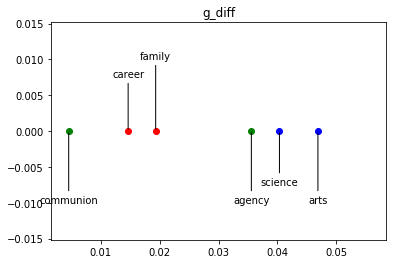

In [65]:
# concepts plot g_diff
fig, ax = plt.subplots()
ax.scatter([mean_science_g_diff, mean_art_g_diff], [0, 0], color='blue')
ax.scatter([mean_career_g_diff, mean_family_g_diff], [0, 0], color='red')
ax.scatter([mean_agency_g_diff, mean_communion_g_diff], [0, 0], color='green')
ax.set_title('g_diff')

plt.annotate('science',
            xy=(mean_science_g_diff, 0),
            xytext=(mean_science_g_diff, -0.0075), 
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))
plt.annotate('arts',
            xy=(mean_art_g_diff, 0),
            xytext=(mean_art_g_diff, -0.01), 
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))
plt.annotate('career',
            xy=(mean_career_g_diff, 0),
            xytext=(mean_career_g_diff, 0.0075), 
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))
plt.annotate('family',
            xy=(mean_family_g_diff, 0),
            xytext=(mean_family_g_diff, 0.01), 
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))
plt.annotate('agency',
            xy=(mean_agency_g_diff, 0),
            xytext=(mean_agency_g_diff, -0.01), 
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))
plt.annotate('communion',
            xy=(mean_communion_g_diff, 0),
            xytext=(mean_communion_g_diff, -0.01), 
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))

plt.show()
fig.savefig('plot/ft_deb_g_diff')

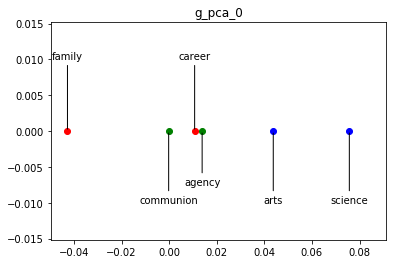

In [66]:
# concepts plot g_pca_0
fig, ax = plt.subplots()
ax.scatter([mean_science_g_pca_0, mean_art_g_pca_0], [0, 0], color='blue')
ax.scatter([mean_career_g_pca_0, mean_family_g_pca_0], [0, 0], color='red')
ax.scatter([mean_agency_g_pca_0, mean_communion_g_pca_0], [0, 0], color='green')
ax.set_title('g_pca_0')

plt.annotate('science',
            xy=(mean_science_g_pca_0, 0),
            xytext=(mean_science_g_pca_0, -0.01), 
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))
plt.annotate('arts',
            xy=(mean_art_g_pca_0, 0),
            xytext=(mean_art_g_pca_0, -0.01), 
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))
plt.annotate('career',
            xy=(mean_career_g_pca_0, 0),
            xytext=(mean_career_g_pca_0, 0.01), 
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))
plt.annotate('family',
            xy=(mean_family_g_pca_0, 0),
            xytext=(mean_family_g_pca_0, 0.01), 
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))
plt.annotate('agency',
            xy=(mean_agency_g_pca_0, 0),
            xytext=(mean_agency_g_pca_0, -0.0075), 
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))
plt.annotate('communion',
            xy=(mean_communion_g_pca_0, 0),
            xytext=(mean_communion_g_pca_0, -0.01), 
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))

plt.show()
fig.savefig('plot/ft_deb_g_pca_0')

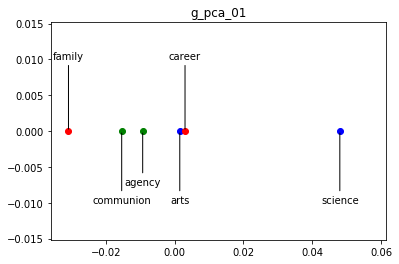

In [67]:
# concepts plot g_pca_01
fig, ax = plt.subplots()
ax.scatter([mean_science_g_pca_01, mean_art_g_pca_01], [0, 0], color='blue')
ax.scatter([mean_career_g_pca_01, mean_family_g_pca_01], [0, 0], color='red')
ax.scatter([mean_agency_g_pca_01, mean_communion_g_pca_01], [0, 0], color='green')
ax.set_title('g_pca_01')

plt.annotate('science',
            xy=(mean_science_g_pca_01, 0),
            xytext=(mean_science_g_pca_01, -0.01), 
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))
plt.annotate('arts',
            xy=(mean_art_g_pca_01, 0),
            xytext=(mean_art_g_pca_01, -0.01), 
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))
plt.annotate('career',
            xy=(mean_career_g_pca_01, 0),
            xytext=(mean_career_g_pca_01, 0.01), 
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))
plt.annotate('family',
            xy=(mean_family_g_pca_01, 0),
            xytext=(mean_family_g_pca_01, 0.01), 
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))
plt.annotate('agency',
            xy=(mean_agency_g_pca_01, 0),
            xytext=(mean_agency_g_pca_01, -0.0075), 
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))
plt.annotate('communion',
            xy=(mean_communion_g_pca_01, 0),
            xytext=(mean_communion_g_pca_01, -0.01), 
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))

plt.show()
fig.savefig('plot/ft_deb_g_pca_01')

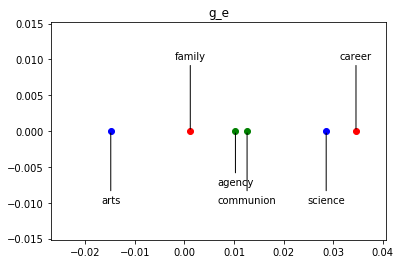

In [68]:
# concepts plot g_e
fig, ax = plt.subplots()
ax.scatter([mean_science_g_e, mean_art_g_e], [0, 0], color='blue')
ax.scatter([mean_career_g_e, mean_family_g_e], [0, 0], color='red')
ax.scatter([mean_agency_g_e, mean_communion_g_e], [0, 0], color='green')
ax.set_title('g_e')

plt.annotate('science',
            xy=(mean_science_g_e, 0),
            xytext=(mean_science_g_e, -0.01), 
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))
plt.annotate('arts',
            xy=(mean_art_g_e, 0),
            xytext=(mean_art_g_e, -0.01), 
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))
plt.annotate('career',
            xy=(mean_career_g_e, 0),
            xytext=(mean_career_g_e, 0.01), 
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))
plt.annotate('family',
            xy=(mean_family_g_e, 0),
            xytext=(mean_family_g_e, 0.01), 
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))
plt.annotate('agency',
            xy=(mean_agency_g_e, 0),
            xytext=(mean_agency_g_e, -0.0075), 
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))
plt.annotate('communion',
            xy=(mean_communion_g_e, 0),
            xytext=(mean_communion_g_e, -0.01), 
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))

plt.show()
fig.savefig('plot/ft_deb_g_e')

### Step 3: working with Gonen's embeddings

#### Step 3.1: repeating steps 2.1-2.6

In [69]:
# gender direction
g_diff = E_g.diff('lui', 'lei')

In [70]:
# list of pairs to define gender
gender_pairs = [['lui','lei'],
                ['uomo','donna'], 
                ['padre','madre'],
                ['marito','moglie'],
                ['fratello','sorella'],
                ['maschio','femmina']]

In [71]:
# PCA
pca = we.doPCA(gender_pairs, E_g)

# PCA components
pc = pca.components_

# singular values
sv = pca.singular_values_

In [72]:
print("Singular values:")
print(sv)

Singular values:
[6.73165823e-01 4.74985087e-01 4.38029897e-01 3.35332203e-01
 2.90767211e-01 2.36732569e-01 1.27794811e-16 1.13799029e-16
 9.10948385e-17 8.73430101e-17]


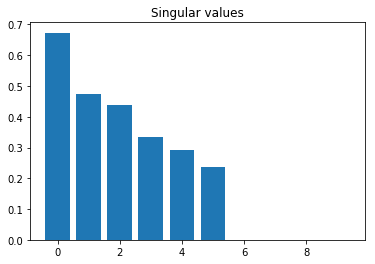

In [73]:
plt.bar(range(pca.n_components_), sv)
plt.title("Singular values")
plt.show()

In [74]:
# gender direction
g_pca_0  = pc[0]/LA.norm(pc[0])
g_pca_01 = (sv[0]*pc[0]+sv[1]*pc[1])/(sv[0]+sv[1])/LA.norm((sv[0]*pc[0]+sv[1]*pc[1])/(sv[0]+sv[1]))

In [75]:
S_word = [['lui','lei'],
          ['uomo','donna'], 
          ['padre','madre'],
          ['marito','moglie'],
          ['fratello','sorella'],
          ['maschio','femmina']]

G_word = db.read('gram_def_mf.txt', 'mf')

In [76]:
S_m_v = []
for w in S_word:
    S_m_v.append(E_g.v(w[1]))
    
S_f_v = []
for w in S_word:
    S_f_v.append(E_g.v(w[0]))
    
G_m_v = []
for w in G_word:
    G_m_v.append(E_g.v(w[0]))
    
G_f_v = []
for w in G_word:
    G_f_v.append(E_g.v(w[1]))

S_m = np.array(S_m_v).T
S_f = np.array(S_f_v).T
G_m = np.array(G_m_v).T
G_f = np.array(G_f_v).T

In [77]:
# delta semantic
Delta_S = np.dot(np.subtract(S_m, S_f), np.subtract(S_m, S_f).T)

# delta grammatical
Delta_G = np.dot(np.subtract(G_m, G_f), np.subtract(G_m, G_f).T)

# A
A = np.dot(np.linalg.inv(Delta_G), Delta_S)

In [78]:
# eigenvalues and eigenvectors
w, v = np.linalg.eig(A)

# gender direction: pick the eigenvector associated to the largest eigenvalue
g_e = v[:,np.argmax(w)] # already normalized

In [79]:
# words
science = ['biologia', 'fisica', 'chimica', 'matematica', 'geologia', 'astronomia', 'ingegneria']
art = ['filosofia', 'umanesimo', 'arte', 'letteratura', 'italiano', 'musica', 'storia']

In [80]:
# compute projections
proj_science_g_diff =  db.prof_proj(E_g, science, g_diff, 'm')
proj_science_g_pca_0 =  db.prof_proj(E_g, science, g_pca_0, 'm')
proj_science_g_pca_01 =  db.prof_proj(E_g, science, g_pca_01, 'm')
proj_science_g_e =  db.prof_proj(E_g, science, g_e, 'm')

proj_art_g_diff =  db.prof_proj(E_g, art, g_diff, 'm')
proj_art_g_pca_0 =  db.prof_proj(E_g, art, g_pca_0, 'm')
proj_art_g_pca_01 =  db.prof_proj(E_g, art, g_pca_01, 'm')
proj_art_g_e =  db.prof_proj(E_g, art, g_e, 'm')

In [81]:
# print science results
science_col0 = [] # pandas columns
science_col1 = []
science_col2 = []
science_col3 = []
science_col4 = []

for i in range(len(proj_art_g_diff)):
    science_col0.append(proj_science_g_diff[i][0]) # word
    science_col1.append(proj_science_g_diff[i][1]) # projection on g_diff
    science_col2.append(proj_science_g_pca_0[i][1]) # projection on g_pca_0
    science_col3.append(proj_science_g_pca_01[i][1]) # projection on g_pca_01
    science_col4.append(np.real(proj_science_g_e[i][1])) # projection on g_e
    
mean_science_g_diff = np.mean(science_col1)
mean_science_g_pca_0 = np.mean(science_col2)
mean_science_g_pca_01 = np.mean(science_col3)
mean_science_g_e = np.mean(science_col4)

science_col0.append('MEAN')
science_col1.append(mean_science_g_diff)
science_col2.append(mean_science_g_pca_0)
science_col3.append(mean_science_g_pca_01)
science_col4.append(mean_science_g_e)

science_data = {'Word':science_col0, 
           'Proj g_diff':science_col1,
           'Proj g_pca_0':science_col2, 
           'Proj g_pca_01':science_col3,
           'Proj g_e':science_col4}

science_table = pd.DataFrame(science_data)
science_table

,Word,Proj g_diff,Proj g_pca_0,Proj g_pca_01,Proj g_e
0,biologia,-0.044219,0.001816,0.000571,-0.035629
1,fisica,-0.006289,0.012623,0.004755,-0.053303
2,chimica,-0.002638,0.030077,0.012071,-0.090114
3,matematica,-0.009425,0.017620,0.031925,-0.049586
4,geologia,0.019303,-0.058702,-0.021255,-0.036167
5,astronomia,0.008334,-0.073903,-0.066562,-0.037463
6,ingegneria,0.023011,-0.066020,-0.094486,-0.038010
7,MEAN,-0.001703,-0.019498,-0.018997,-0.048610


In [82]:
# print arts results
art_col0 = [] # pandas columns
art_col1 = []
art_col2 = []
art_col3 = []
art_col4 = []

for i in range(len(proj_art_g_diff)):
    art_col0.append(proj_art_g_diff[i][0]) # word
    art_col1.append(proj_art_g_diff[i][1]) # projection on g_diff
    art_col2.append(proj_art_g_pca_0[i][1]) # projection on g_pca_0
    art_col3.append(proj_art_g_pca_01[i][1]) # projection on g_pca_01
    art_col4.append(np.real(proj_art_g_e[i][1])) # projection on g_e
    
mean_art_g_diff = np.mean(art_col1)
mean_art_g_pca_0 = np.mean(art_col2)
mean_art_g_pca_01 = np.mean(art_col3)
mean_art_g_e = np.mean(art_col4)

art_col0.append('MEAN')
art_col1.append(mean_art_g_diff)
art_col2.append(mean_art_g_pca_0)
art_col3.append(mean_art_g_pca_01)
art_col4.append(mean_art_g_e)

art_data = {'Word':art_col0, 
           'Proj g_diff':art_col1,
           'Proj g_pca_0':art_col2, 
           'Proj g_pca_01':art_col3,
           'Proj g_e':art_col4}

art_table = pd.DataFrame(art_data)
art_table

,Word,Proj g_diff,Proj g_pca_0,Proj g_pca_01,Proj g_e
0,filosofia,-0.021477,-0.033146,-0.015984,0.019274
1,umanesimo,0.086165,-0.165222,-0.150388,0.041303
2,arte,0.046498,-0.080162,-0.046071,-0.010162
3,letteratura,-0.015380,0.016395,0.026491,0.027518
4,italiano,0.079357,-0.144177,-0.103304,0.076797
5,musica,-0.093242,0.037348,0.070707,0.063072
6,storia,0.003129,0.033212,0.091538,0.101399
7,MEAN,0.012150,-0.047965,-0.018144,0.045600


In [83]:
# words
# executive, management, professional, corporation, salary, office, business, career
career = ['esecutivo', 'amministrazione', 'professionale', 'società', 'stipendio', 'ufficio', 'business', 'carriera']
# home, parents, children, family, cousins, marriage, wedding, relatives
family = ['casa', 'familiari', 'bambini', 'famiglia', 'cugini', 'matrimonio', 'parenti']

In [84]:
# compute projections
proj_career_g_diff =  db.prof_proj(E_g, career, g_diff, 'm')
proj_career_g_pca_0 =  db.prof_proj(E_g, career, g_pca_0, 'm')
proj_career_g_pca_01 =  db.prof_proj(E_g, career, g_pca_01, 'm')
proj_career_g_e =  db.prof_proj(E_g, career, g_e, 'm')

proj_family_g_diff =  db.prof_proj(E_g, family, g_diff, 'm')
proj_family_g_pca_0 =  db.prof_proj(E_g, family, g_pca_0, 'm')
proj_family_g_pca_01 =  db.prof_proj(E_g, family, g_pca_01, 'm')
proj_family_g_e =  db.prof_proj(E_g, family, g_e, 'm')

In [85]:
# print career results
career_col0 = [] # pandas columns
career_col1 = []
career_col2 = []
career_col3 = []
career_col4 = []

for i in range(len(proj_career_g_diff)):
    career_col0.append(proj_career_g_diff[i][0]) # word
    career_col1.append(proj_career_g_diff[i][1]) # projection on g_diff
    career_col2.append(proj_career_g_pca_0[i][1]) # projection on g_pca_0
    career_col3.append(proj_career_g_pca_01[i][1]) # projection on g_pca_01
    career_col4.append(np.real(proj_career_g_e[i][1])) # projection on g_e
    
mean_career_g_diff = np.mean(career_col1)
mean_career_g_pca_0 = np.mean(career_col2)
mean_career_g_pca_01 = np.mean(career_col3)
mean_career_g_e = np.mean(career_col4)

career_col0.append('MEAN')
career_col1.append(mean_career_g_diff)
career_col2.append(mean_career_g_pca_0)
career_col3.append(mean_career_g_pca_01)
career_col4.append(mean_career_g_e)

career_data = {'Word':career_col0, 
               'Proj g_diff':career_col1,
               'Proj g_pca_0':career_col2, 
               'Proj g_pca_01':career_col3,
               'Proj g_e':career_col4}

career_table = pd.DataFrame(career_data)
career_table

,Word,Proj g_diff,Proj g_pca_0,Proj g_pca_01,Proj g_e
0,esecutivo,0.064552,-0.091959,-0.103867,0.020567
1,amministrazione,0.044434,-0.100009,-0.075188,0.003465
2,professionale,-0.021096,-0.040342,0.037210,-0.045710
3,società,0.025567,0.018073,0.037034,0.021117
4,stipendio,-0.007619,-0.039384,-0.036191,0.020262
5,ufficio,0.045041,-0.091166,-0.104362,0.016083
6,business,-0.064340,0.015323,0.000243,-0.029151
7,carriera,-0.037302,0.015136,0.086645,0.091747
8,MEAN,0.006154,-0.039291,-0.019809,0.012297


In [86]:
# print family results
family_col0 = [] # pandas columns
family_col1 = []
family_col2 = []
family_col3 = []
family_col4 = []

for i in range(len(proj_art_g_diff)):
    family_col0.append(proj_family_g_diff[i][0]) # word
    family_col1.append(proj_family_g_diff[i][1]) # projection on g_diff
    family_col2.append(proj_family_g_pca_0[i][1]) # projection on g_pca_0
    family_col3.append(proj_family_g_pca_01[i][1]) # projection on g_pca_01
    family_col4.append(np.real(proj_family_g_e[i][1])) # projection on g_e
    
mean_family_g_diff = np.mean(family_col1)
mean_family_g_pca_0 = np.mean(family_col2)
mean_family_g_pca_01 = np.mean(family_col3)
mean_family_g_e = np.mean(family_col4)

family_col0.append('MEAN')
family_col1.append(mean_family_g_diff)
family_col2.append(mean_family_g_pca_0)
family_col3.append(mean_family_g_pca_01)
family_col4.append(mean_family_g_e)

family_data = {'Word':family_col0, 
               'Proj g_diff':family_col1,
               'Proj g_pca_0':family_col2, 
               'Proj g_pca_01':family_col3,
               'Proj g_e':family_col4}

family_table = pd.DataFrame(family_data)
family_table

,Word,Proj g_diff,Proj g_pca_0,Proj g_pca_01,Proj g_e
0,casa,-0.028512,0.087615,0.081517,0.038837
1,familiari,-0.044820,0.033277,-0.027543,0.025229
2,bambini,-0.148569,0.113252,0.102402,-0.001513
3,famiglia,-0.078728,0.053165,0.079375,-0.039562
4,cugini,-0.028462,-0.051461,0.015240,-0.018717
5,matrimonio,-0.249898,0.199806,0.286101,-0.066381
6,parenti,-0.083432,0.049454,0.056959,0.002886
7,MEAN,-0.094632,0.069301,0.084864,-0.008460


In [87]:
# words
agency = db.read('ag_ita.txt', 'ag-com')
communion = db.read('com_ita.txt', 'ag-com')

In [88]:
agency_pos = ['abile', 'attivo', 'creativo', 'indipendente', 'intelligente', 'determinato', 'razionale', 'autonomo',
         'deciso', 'capace', 'competente', 'vigoroso', 'combattivo', 'ambizioso']

communion_pos = ['educato', 'giusto', 'aperto', 'disponibile', 'leale', 'sensibile', 'empatico', 'fiducioso', 'comprensivo', 
                 'coscienzioso', 'supportivo', 'altruista']

agency_lack = ['timido', 'credulone', 'vulnerabile']

communion_lack = ['distaccato', 'egoista', 'rigido']

In [89]:
# compute projections
proj_agency_g_diff =  db.prof_proj(E_g, agency, g_diff, 'ag-com')
proj_agency_g_pca_0 =  db.prof_proj(E_g, agency, g_pca_0, 'ag-com')
proj_agency_g_pca_01 =  db.prof_proj(E_g, agency, g_pca_01, 'ag-com')
proj_agency_g_e =  db.prof_proj(E_g, agency, g_e, 'ag-com')

proj_communion_g_diff =  db.prof_proj(E_g, communion, g_diff, 'ag-com')
proj_communion_g_pca_0 =  db.prof_proj(E_g, communion, g_pca_0, 'ag-com')
proj_communion_g_pca_01 =  db.prof_proj(E_g, communion, g_pca_01, 'ag-com')
proj_communion_g_e =  db.prof_proj(E_g, communion, g_e, 'ag-com')

In [90]:
# print agency results
agency_col0 = [] # pandas columns
agency_col1 = []
agency_col2 = []
agency_col3 = []
agency_col4 = []
agency_col5 = []

for i in range(len(proj_agency_g_diff)):
    agency_col0.append(proj_agency_g_diff[i][0]) # word
    agency_col1.append(proj_agency_g_diff[i][1]) # projection on g_diff
    agency_col2.append(proj_agency_g_pca_0[i][1]) # projection on g_pca_0
    agency_col3.append(proj_agency_g_pca_01[i][1]) # projection on g_pca_01
    agency_col4.append(np.real(proj_agency_g_e[i][1])) # projection on g_e
    agency_col5.append(proj_agency_g_diff[i][2]) # agency score
    
mean_agency_g_diff = np.mean(agency_col1)
mean_agency_g_pca_0 = np.mean(agency_col2)
mean_agency_g_pca_01 = np.mean(agency_col3)
mean_agency_g_e = np.mean(agency_col4)
mean_agency_score = np.mean(agency_col5)

agency_col0.append('MEAN')
agency_col1.append(mean_agency_g_diff)
agency_col2.append(mean_agency_g_pca_0)
agency_col3.append(mean_agency_g_pca_01)
agency_col4.append(mean_agency_g_e)
agency_col5.append(mean_agency_score)

agency_data = {'Word':agency_col0, 
               'Proj g_diff':agency_col1,
               'Proj g_pca_0':agency_col2, 
               'Proj g_pca_01':agency_col3,
               'Proj g_e':agency_col4,
               'Agency':agency_col5}

agency_table = pd.DataFrame(agency_data)
agency_table

,Word,Proj g_diff,Proj g_pca_0,Proj g_pca_01,Proj g_e,Agency
0,abile,0.059056,-0.113135,-0.023355,0.112070,2.320000
1,attivo,0.017886,-0.094562,-0.052168,0.032997,2.350000
2,ambizioso,0.000125,-0.104148,-0.052351,-0.001439,2.790000
3,deciso,-0.119423,0.033008,0.027678,0.012721,2.880000
4,vanitoso,-0.155557,0.034814,0.046701,0.006040,1.290000
5,capace,0.026271,-0.020479,-0.026877,0.053098,2.450000
6,competente,0.059333,-0.066472,-0.013275,0.059932,2.210000
7,competitivo,0.018908,-0.112277,-0.080623,-0.028378,2.710000
8,presuntuoso,-0.083870,-0.013392,0.018782,0.028906,1.530000
9,creativo,0.007551,-0.084638,-0.067651,-0.020522,1.630000


In [91]:
# agency pearson correlation
r_agency_g_diff = scipy.stats.pearsonr(agency_col5, agency_col1)[0]
r_agency_g_pca_0 = scipy.stats.pearsonr(agency_col5, agency_col2)[0]
r_agency_g_pca_01 = scipy.stats.pearsonr(agency_col5, agency_col3)[0]
r_agency_g_e = scipy.stats.pearsonr(agency_col5, agency_col4)[0]

In [92]:
pearson_data = {'g_diff':r_agency_g_diff,
                'g_pca_0':r_agency_g_pca_0,
                'g_pca_01':r_agency_g_pca_01,
                'g_e':r_agency_g_e}
pearson_table = pd.DataFrame(pearson_data, index=['r'])
pearson_table

,g_diff,g_pca_0,g_pca_01,g_e
r,0.180409,-0.358817,-0.265601,-0.332545


In [93]:
# print communion results
communion_col0 = [] # pandas columns
communion_col1 = []
communion_col2 = []
communion_col3 = []
communion_col4 = []
communion_col5 = []

for i in range(len(proj_communion_g_diff)):
    communion_col0.append(proj_communion_g_diff[i][0]) # word
    communion_col1.append(proj_communion_g_diff[i][1]) # projection on g_diff
    communion_col2.append(proj_communion_g_pca_0[i][1]) # projection on g_pca_0
    communion_col3.append(proj_communion_g_pca_01[i][1]) # projection on g_pca_01
    communion_col4.append(np.real(proj_communion_g_e[i][1])) # projection on g_e
    communion_col5.append(proj_communion_g_diff[i][2]) # communion score

mean_communion_g_diff = np.mean(communion_col1)
mean_communion_g_pca_0 = np.mean(communion_col2)
mean_communion_g_pca_01 = np.mean(communion_col3)
mean_communion_g_e = np.mean(communion_col4)
mean_communion_score = np.mean(communion_col5)

communion_col0.append('MEAN')
communion_col1.append(mean_communion_g_diff)
communion_col2.append(mean_communion_g_pca_0)
communion_col3.append(mean_communion_g_pca_01)
communion_col4.append(mean_communion_g_e)
communion_col5.append(mean_communion_score)

communion_data = {'Word':communion_col0, 
               'Proj g_diff':communion_col1,
               'Proj g_pca_0':communion_col2, 
               'Proj g_pca_01':communion_col3,
               'Proj g_e':communion_col4,
               'communion':communion_col5}

communion_table = pd.DataFrame(communion_data)
communion_table

,Word,Proj g_diff,Proj g_pca_0,Proj g_pca_01,Proj g_e,communion
0,affettuoso,-0.127809,0.016065,0.070109,0.013732,1.5800
1,altruista,-0.115441,-0.013627,0.008819,0.065061,2.5000
2,comunicativo,-0.035811,-0.092983,-0.106942,-0.001147,2.0000
3,coscienzioso,0.005012,-0.114055,-0.072775,-0.045004,1.3200
4,rispettoso,0.048962,-0.142337,-0.065556,0.051218,1.5500
5,coerente,0.021684,-0.035207,-0.037364,-0.014060,1.6800
6,emotivo,-0.115930,-0.010283,0.027551,0.020937,1.3700
7,giusto,0.043608,-0.070941,-0.014572,0.021177,1.9500
8,socievole,-0.142771,0.010607,-0.006720,-0.002590,2.2300
9,disponibile,-0.116799,0.034990,0.024886,0.017821,2.7600


In [94]:
# communion pearson correlation
r_communion_g_diff = scipy.stats.pearsonr(communion_col5, communion_col1)[0]
r_communion_g_pca_0 = scipy.stats.pearsonr(communion_col5, communion_col2)[0]
r_communion_g_pca_01 = scipy.stats.pearsonr(communion_col5, communion_col3)[0]
r_communion_g_e = scipy.stats.pearsonr(communion_col5, communion_col4)[0]

In [95]:
pearson_data = {'g_diff':r_communion_g_diff,
                'g_pca_0':r_communion_g_pca_0,
                'g_pca_01':r_communion_g_pca_01,
                'g_e':r_communion_g_e}
pearson_table = pd.DataFrame(pearson_data, index=['r'])
pearson_table

,g_diff,g_pca_0,g_pca_01,g_e
r,0.056448,0.086249,0.115237,-0.262596


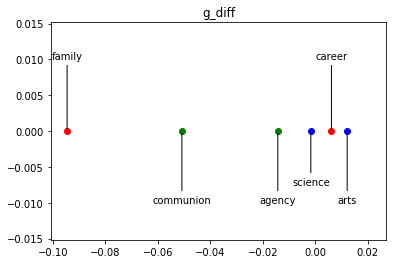

In [96]:
# concepts plot g_diff
fig, ax = plt.subplots()
ax.scatter([mean_science_g_diff, mean_art_g_diff], [0, 0], color='blue')
ax.scatter([mean_career_g_diff, mean_family_g_diff], [0, 0], color='red')
ax.scatter([mean_agency_g_diff, mean_communion_g_diff], [0, 0], color='green')
ax.set_title('g_diff')

plt.annotate('science',
            xy=(mean_science_g_diff, 0),
            xytext=(mean_science_g_diff, -0.0075), 
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))
plt.annotate('arts',
            xy=(mean_art_g_diff, 0),
            xytext=(mean_art_g_diff, -0.01), 
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))
plt.annotate('career',
            xy=(mean_career_g_diff, 0),
            xytext=(mean_career_g_diff, 0.01), 
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))
plt.annotate('family',
            xy=(mean_family_g_diff, 0),
            xytext=(mean_family_g_diff, 0.01), 
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))
plt.annotate('agency',
            xy=(mean_agency_g_diff, 0),
            xytext=(mean_agency_g_diff, -0.01), 
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))
plt.annotate('communion',
            xy=(mean_communion_g_diff, 0),
            xytext=(mean_communion_g_diff, -0.01), 
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))

plt.show()
fig.savefig('plot/g_g_diff')

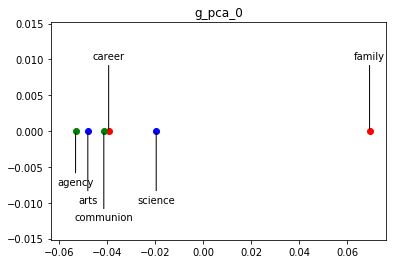

In [97]:
# concepts plot g_pca_0
fig, ax = plt.subplots()
ax.scatter([mean_science_g_pca_0, mean_art_g_pca_0], [0, 0], color='blue')
ax.scatter([mean_career_g_pca_0, mean_family_g_pca_0], [0, 0], color='red')
ax.scatter([mean_agency_g_pca_0, mean_communion_g_pca_0], [0, 0], color='green')
ax.set_title('g_pca_0')

plt.annotate('science',
            xy=(mean_science_g_pca_0, 0),
            xytext=(mean_science_g_pca_0, -0.01), 
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))
plt.annotate('arts',
            xy=(mean_art_g_pca_0, 0),
            xytext=(mean_art_g_pca_0, -0.01), 
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))
plt.annotate('career',
            xy=(mean_career_g_pca_0, 0),
            xytext=(mean_career_g_pca_0, 0.01), 
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))
plt.annotate('family',
            xy=(mean_family_g_pca_0, 0),
            xytext=(mean_family_g_pca_0, 0.01), 
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))
plt.annotate('agency',
            xy=(mean_agency_g_pca_0, 0),
            xytext=(mean_agency_g_pca_0, -0.0075), 
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))
plt.annotate('communion',
            xy=(mean_communion_g_pca_0, 0),
            xytext=(mean_communion_g_pca_0, -0.0125), 
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))

plt.show()
fig.savefig('plot/g_g_pca_0')

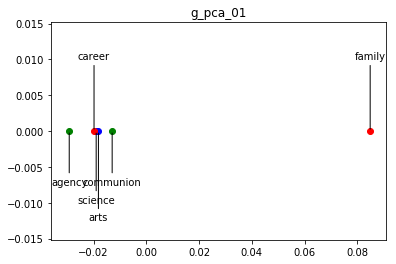

In [98]:
# concepts plot g_pca_01
fig, ax = plt.subplots()
ax.scatter([mean_science_g_pca_01, mean_art_g_pca_01], [0, 0], color='blue')
ax.scatter([mean_career_g_pca_01, mean_family_g_pca_01], [0, 0], color='red')
ax.scatter([mean_agency_g_pca_01, mean_communion_g_pca_01], [0, 0], color='green')
ax.set_title('g_pca_01')

plt.annotate('science',
            xy=(mean_science_g_pca_01, 0),
            xytext=(mean_science_g_pca_01, -0.01), 
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))
plt.annotate('arts',
            xy=(mean_art_g_pca_01, 0),
            xytext=(mean_art_g_pca_01, -0.0125), 
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))
plt.annotate('career',
            xy=(mean_career_g_pca_01, 0),
            xytext=(mean_career_g_pca_01, 0.01), 
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))
plt.annotate('family',
            xy=(mean_family_g_pca_01, 0),
            xytext=(mean_family_g_pca_01, 0.01), 
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))
plt.annotate('agency',
            xy=(mean_agency_g_pca_01, 0),
            xytext=(mean_agency_g_pca_01, -0.0075), 
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))
plt.annotate('communion',
            xy=(mean_communion_g_pca_01, 0),
            xytext=(mean_communion_g_pca_01, -0.0075), 
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))

plt.show()
fig.savefig('plot/g_g_pca_01')

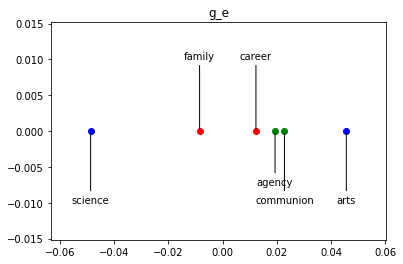

In [136]:
# concepts plot g_e
fig, ax = plt.subplots()
ax.scatter([mean_science_g_e, mean_art_g_e], [0, 0], color='blue')
ax.scatter([mean_career_g_e, mean_family_g_e], [0, 0], color='red')
ax.scatter([mean_agency_g_e, mean_communion_g_e], [0, 0], color='green')
ax.set_title('g_e')

plt.annotate('science',
            xy=(mean_science_g_e, 0),
            xytext=(mean_science_g_e, -0.01), 
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))
plt.annotate('arts',
            xy=(mean_art_g_e, 0),
            xytext=(mean_art_g_e, -0.01), 
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))
plt.annotate('career',
            xy=(mean_career_g_e, 0),
            xytext=(mean_career_g_e, 0.01), 
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))
plt.annotate('family',
            xy=(mean_family_g_e, 0),
            xytext=(mean_family_g_e, 0.01), 
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))
plt.annotate('agency',
            xy=(mean_agency_g_e, 0),
            xytext=(mean_agency_g_e, -0.0075), 
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))
plt.annotate('communion',
            xy=(mean_communion_g_e, 0),
            xytext=(mean_communion_g_e, -0.01), 
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))

plt.show()
fig.savefig('plot/g_g_e')

In [157]:
# gender analysis
gender_pairs = [['lui','lei'],
                ['uomo','donna'], 
                ['padre','madre'],
                ['marito','moglie'],
                ['fratello','sorella'],
                ['maschio','femmina']]

In [168]:
gender_pairs_proj_g_diff = []
gender_pairs_proj_g_pca_0 = []
gender_pairs_proj_g_pca_01 = []
gender_pairs_proj_g_e = []

for pair in gender_pairs:
    gender_pairs_proj_g_diff.append([np.dot(E_g.v(pair[0]), g_diff), np.dot(E_g.v(pair[1]), g_diff)])
    gender_pairs_proj_g_pca_0.append([np.dot(E_g.v(pair[0]), g_pca_0), np.dot(E_g.v(pair[1]), g_pca_0)])
    gender_pairs_proj_g_pca_01.append([np.dot(E_g.v(pair[0]), g_pca_01), np.dot(E_g.v(pair[1]), g_pca_01)])
    gender_pairs_proj_g_e.append([np.real(np.dot(E_g.v(pair[0]), g_e)), np.real(np.dot(E_g.v(pair[1]), g_e))])

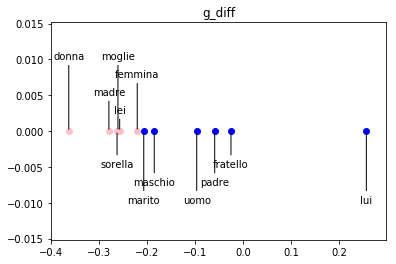

In [166]:
fig, ax = plt.subplots()

for pair in gender_pairs_proj_g_diff:
    ax.scatter(pair[0], 0, color='blue')
    ax.scatter(pair[1], 0, color='pink')

ax.set_title('g_diff')

plt.annotate(gender_pairs[0][0],
            xy=(gender_pairs_proj_g_diff[0][0], 0),
            xytext=(gender_pairs_proj_g_diff[0][0], -0.01),
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))

plt.annotate(gender_pairs[1][0],
            xy=(gender_pairs_proj_g_diff[1][0], 0),
            xytext=(gender_pairs_proj_g_diff[1][0], -0.01),
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))

plt.annotate(gender_pairs[2][0],
            xy=(gender_pairs_proj_g_diff[2][0], 0),
            xytext=(gender_pairs_proj_g_diff[2][0], -0.0075),
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))

plt.annotate(gender_pairs[3][0],
            xy=(gender_pairs_proj_g_diff[3][0], 0),
            xytext=(gender_pairs_proj_g_diff[3][0], -0.01),
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))

plt.annotate(gender_pairs[4][0],
            xy=(gender_pairs_proj_g_diff[4][0], 0),
            xytext=(gender_pairs_proj_g_diff[4][0], -0.005),
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))

plt.annotate(gender_pairs[5][0],
            xy=(gender_pairs_proj_g_diff[5][0], 0),
            xytext=(gender_pairs_proj_g_diff[5][0], -0.0075),
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))

plt.annotate(gender_pairs[0][1],
            xy=(gender_pairs_proj_g_diff[0][1], 0),
            xytext=(gender_pairs_proj_g_diff[0][1], 0.0025),
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))

plt.annotate(gender_pairs[1][1],
            xy=(gender_pairs_proj_g_diff[1][1], 0),
            xytext=(gender_pairs_proj_g_diff[1][1], 0.01),
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))

plt.annotate(gender_pairs[2][1],
            xy=(gender_pairs_proj_g_diff[2][1], 0),
            xytext=(gender_pairs_proj_g_diff[2][1], 0.005),
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))

plt.annotate(gender_pairs[3][1],
            xy=(gender_pairs_proj_g_diff[3][1], 0),
            xytext=(gender_pairs_proj_g_diff[3][1], 0.01),
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))

plt.annotate(gender_pairs[4][1],
            xy=(gender_pairs_proj_g_diff[4][1], 0),
            xytext=(gender_pairs_proj_g_diff[4][1], -0.005),
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))

plt.annotate(gender_pairs[5][1],
            xy=(gender_pairs_proj_g_diff[5][1], 0),
            xytext=(gender_pairs_proj_g_diff[5][1], 0.0075),
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))

plt.show()
fig.savefig('plot/gonen-gender-analysis/g_g_diff')

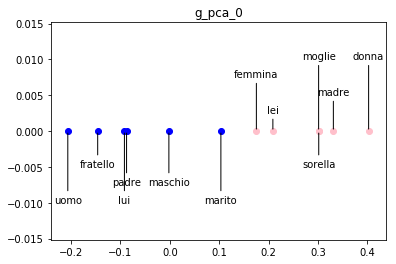

In [165]:
fig, ax = plt.subplots()

for pair in gender_pairs_proj_g_pca_0:
    ax.scatter(pair[0], 0, color='blue')
    ax.scatter(pair[1], 0, color='pink')

ax.set_title('g_pca_0')

plt.annotate(gender_pairs[0][0],
            xy=(gender_pairs_proj_g_pca_0[0][0], 0),
            xytext=(gender_pairs_proj_g_pca_0[0][0], -0.01),
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))

plt.annotate(gender_pairs[1][0],
            xy=(gender_pairs_proj_g_pca_0[1][0], 0),
            xytext=(gender_pairs_proj_g_pca_0[1][0], -0.01),
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))

plt.annotate(gender_pairs[2][0],
            xy=(gender_pairs_proj_g_pca_0[2][0], 0),
            xytext=(gender_pairs_proj_g_pca_0[2][0], -0.0075),
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))

plt.annotate(gender_pairs[3][0],
            xy=(gender_pairs_proj_g_pca_0[3][0], 0),
            xytext=(gender_pairs_proj_g_pca_0[3][0], -0.01),
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))

plt.annotate(gender_pairs[4][0],
            xy=(gender_pairs_proj_g_pca_0[4][0], 0),
            xytext=(gender_pairs_proj_g_pca_0[4][0], -0.005),
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))

plt.annotate(gender_pairs[5][0],
            xy=(gender_pairs_proj_g_pca_0[5][0], 0),
            xytext=(gender_pairs_proj_g_pca_0[5][0], -0.0075),
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))

plt.annotate(gender_pairs[0][1],
            xy=(gender_pairs_proj_g_pca_0[0][1], 0),
            xytext=(gender_pairs_proj_g_pca_0[0][1], 0.0025),
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))

plt.annotate(gender_pairs[1][1],
            xy=(gender_pairs_proj_g_pca_0[1][1], 0),
            xytext=(gender_pairs_proj_g_pca_0[1][1], 0.01),
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))

plt.annotate(gender_pairs[2][1],
            xy=(gender_pairs_proj_g_pca_0[2][1], 0),
            xytext=(gender_pairs_proj_g_pca_0[2][1], 0.005),
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))

plt.annotate(gender_pairs[3][1],
            xy=(gender_pairs_proj_g_pca_0[3][1], 0),
            xytext=(gender_pairs_proj_g_pca_0[3][1], 0.01),
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))

plt.annotate(gender_pairs[4][1],
            xy=(gender_pairs_proj_g_pca_0[4][1], 0),
            xytext=(gender_pairs_proj_g_pca_0[4][1], -0.005),
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))

plt.annotate(gender_pairs[5][1],
            xy=(gender_pairs_proj_g_pca_0[5][1], 0),
            xytext=(gender_pairs_proj_g_pca_0[5][1], 0.0075),
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))

plt.show()
fig.savefig('plot/gonen-gender-analysis/g_g_pca_0')

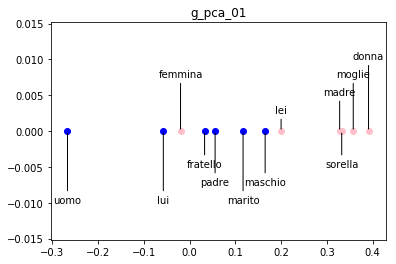

In [164]:
fig, ax = plt.subplots()

for pair in gender_pairs_proj_g_pca_01:
    ax.scatter(pair[0], 0, color='blue')
    ax.scatter(pair[1], 0, color='pink')

ax.set_title('g_pca_01')

plt.annotate(gender_pairs[0][0],
            xy=(gender_pairs_proj_g_pca_01[0][0], 0),
            xytext=(gender_pairs_proj_g_pca_01[0][0], -0.01),
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))

plt.annotate(gender_pairs[1][0],
            xy=(gender_pairs_proj_g_pca_01[1][0], 0),
            xytext=(gender_pairs_proj_g_pca_01[1][0], -0.01),
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))

plt.annotate(gender_pairs[2][0],
            xy=(gender_pairs_proj_g_pca_01[2][0], 0),
            xytext=(gender_pairs_proj_g_pca_01[2][0], -0.0075),
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))

plt.annotate(gender_pairs[3][0],
            xy=(gender_pairs_proj_g_pca_01[3][0], 0),
            xytext=(gender_pairs_proj_g_pca_01[3][0], -0.01),
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))

plt.annotate(gender_pairs[4][0],
            xy=(gender_pairs_proj_g_pca_01[4][0], 0),
            xytext=(gender_pairs_proj_g_pca_01[4][0], -0.005),
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))

plt.annotate(gender_pairs[5][0],
            xy=(gender_pairs_proj_g_pca_01[5][0], 0),
            xytext=(gender_pairs_proj_g_pca_01[5][0], -0.0075),
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))

plt.annotate(gender_pairs[0][1],
            xy=(gender_pairs_proj_g_pca_01[0][1], 0),
            xytext=(gender_pairs_proj_g_pca_01[0][1], 0.0025),
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))

plt.annotate(gender_pairs[1][1],
            xy=(gender_pairs_proj_g_pca_01[1][1], 0),
            xytext=(gender_pairs_proj_g_pca_01[1][1], 0.01),
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))

plt.annotate(gender_pairs[2][1],
            xy=(gender_pairs_proj_g_pca_01[2][1], 0),
            xytext=(gender_pairs_proj_g_pca_01[2][1], 0.005),
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))

plt.annotate(gender_pairs[3][1],
            xy=(gender_pairs_proj_g_pca_01[3][1], 0),
            xytext=(gender_pairs_proj_g_pca_01[3][1], 0.0075),
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))

plt.annotate(gender_pairs[4][1],
            xy=(gender_pairs_proj_g_pca_01[4][1], 0),
            xytext=(gender_pairs_proj_g_pca_01[4][1], -0.005),
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))

plt.annotate(gender_pairs[5][1],
            xy=(gender_pairs_proj_g_pca_01[5][1], 0),
            xytext=(gender_pairs_proj_g_pca_01[5][1], 0.0075),
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))

plt.show()
fig.savefig('plot/gonen-gender-analysis/g_g_pca_01')

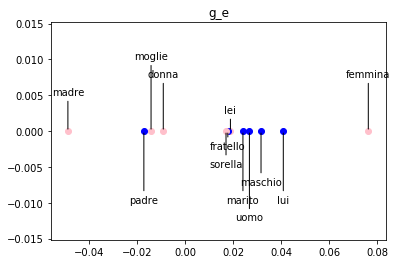

In [174]:
fig, ax = plt.subplots()

for pair in gender_pairs_proj_g_e:
    ax.scatter(pair[0], 0, color='blue')
    ax.scatter(pair[1], 0, color='pink')

ax.set_title('g_e')

plt.annotate(gender_pairs[0][0],
            xy=(gender_pairs_proj_g_e[0][0], 0),
            xytext=(gender_pairs_proj_g_e[0][0], -0.01),
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))

plt.annotate(gender_pairs[1][0],
            xy=(gender_pairs_proj_g_e[1][0], 0),
            xytext=(gender_pairs_proj_g_e[1][0], -0.0125),
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))

plt.annotate(gender_pairs[2][0],
            xy=(gender_pairs_proj_g_e[2][0], 0),
            xytext=(gender_pairs_proj_g_e[2][0], -0.01),
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))

plt.annotate(gender_pairs[3][0],
            xy=(gender_pairs_proj_g_e[3][0], 0),
            xytext=(gender_pairs_proj_g_e[3][0], -0.01),
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))

plt.annotate(gender_pairs[4][0],
            xy=(gender_pairs_proj_g_e[4][0], 0),
            xytext=(gender_pairs_proj_g_e[4][0], -0.0025),
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))

plt.annotate(gender_pairs[5][0],
            xy=(gender_pairs_proj_g_e[5][0], 0),
            xytext=(gender_pairs_proj_g_e[5][0], -0.0075),
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))

plt.annotate(gender_pairs[0][1],
            xy=(gender_pairs_proj_g_e[0][1], 0),
            xytext=(gender_pairs_proj_g_e[0][1], 0.0025),
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))

plt.annotate(gender_pairs[1][1],
            xy=(gender_pairs_proj_g_e[1][1], 0),
            xytext=(gender_pairs_proj_g_e[1][1], 0.0075),
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))

plt.annotate(gender_pairs[2][1],
            xy=(gender_pairs_proj_g_e[2][1], 0),
            xytext=(gender_pairs_proj_g_e[2][1], 0.005),
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))

plt.annotate(gender_pairs[3][1],
            xy=(gender_pairs_proj_g_e[3][1], 0),
            xytext=(gender_pairs_proj_g_e[3][1], 0.01),
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))

plt.annotate(gender_pairs[4][1],
            xy=(gender_pairs_proj_g_e[4][1], 0),
            xytext=(gender_pairs_proj_g_e[4][1], -0.005),
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))

plt.annotate(gender_pairs[5][1],
            xy=(gender_pairs_proj_g_e[5][1], 0),
            xytext=(gender_pairs_proj_g_e[5][1], 0.0075),
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='-'))

plt.show()
fig.savefig('plot/gonen-gender-analysis/g_g_e')